In [2]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from __future__ import print_function
import numpy
import tensorflow as tf
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as K
from matplotlib import pyplot as plt
import scipy
from keras.applications import vgg16

from pathlib import Path
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input

In [3]:
seed = 123
zoom = 2
downscale_fact = 2

image_height_orig = 720
image_width_orig = 1280

image_height_ds = image_height_orig // downscale_fact
image_width_ds = image_width_orig // downscale_fact

image_height = 256
image_width = 256

images_path = '../images'
batch_size = 16

train_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    validation_split=0.2,
)

train_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    subset='training',
    # seed=seed,
)

test_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    subset='validation',
    # seed=seed,
)


def crop_img(img):
    y = np.random.randint(0, img.shape[0] - image_height)
    x = np.random.randint(0, img.shape[1] - image_width)
    return img[y:y+image_height, x:x+image_width]


def preprocess_generator(generator):
    while True:
        images = next(generator)
        images_input = np.zeros((images.shape[0], image_height, image_width, 3))
        images_output = np.zeros((images.shape[0], image_height, image_width, 3))
        for i in range(images.shape[0]):
            cropped_img = crop_img(images[i])
            images_output[i] = cropped_img / 255.
            images_input[i] = cropped_img
            vgg16.preprocess_input(images_input[i])
        yield images_input, images_output


def intput_to_output(images):
    return (images + 128.) / 255.

train_ds_prep = preprocess_generator(train_ds)
test_ds_prep = preprocess_generator(test_ds)

Found 3407 images belonging to 1 classes.
Found 851 images belonging to 1 classes.


Input image constraints: -123.68 151.061
Output image constraints: 0.0 1.0


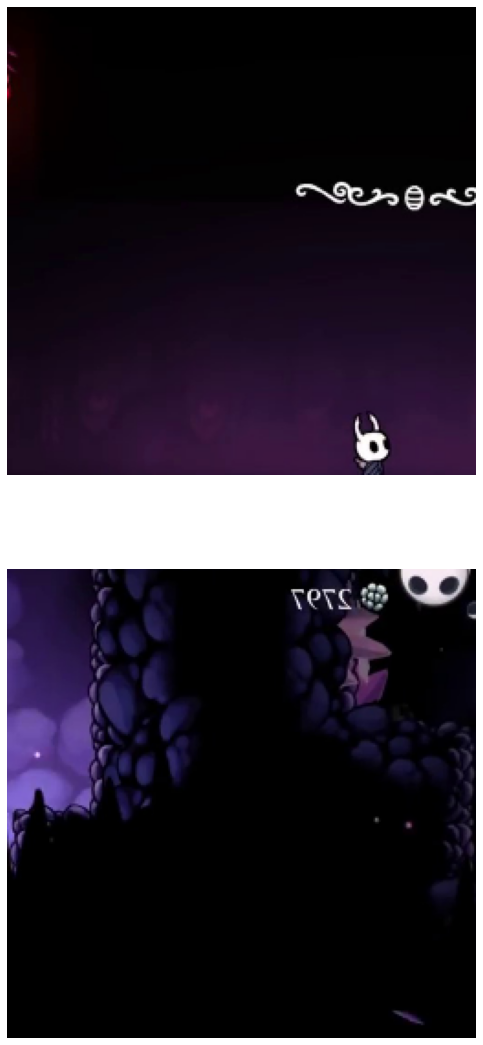

In [4]:
plt.figure(figsize=(50, 50))
images = next(train_ds_prep)
print('Input image constraints:', np.min(images[0]), np.max(images[0]))
print('Output image constraints:', np.min(images[1]), np.max(images[1]))
for i, image in enumerate(images[1][:2]):
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(image)
    plt.axis("off")

train_ds.reset()

In [5]:

from keras import Sequential
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, UpSampling2D, Conv2D, LeakyReLU, Conv2DTranspose, ZeroPadding2D, BatchNormalization, \
    Dropout, Activation


def create_model_mobilenet():
    conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    model = Sequential(conv_base.layers[:-15])

    model.add(Conv2D(128, kernel_size=(1, 1), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, name='encoded', kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(3, kernel_size=(7, 7), strides=(2, 2), activation='sigmoid', padding='same', name='decoded'))

    return model, conv_base


def create_model_vgg16():
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    model = Sequential(conv_base.layers[:-1])

    model.add(BatchNormalization())
    # model.add(Conv2D(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(Activation('leaky_relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu', name='encoded', dtype='float16'))



    model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    # model.add(Conv2DTranspose(32, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(32, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    # model.add(Conv2DTranspose(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(Activation('leaky_relu'))
    #
    # model.add(Conv2DTranspose(16, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('leaky_relu'))

    model.add(Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), activation='sigmoid', padding='same', name='decoded'))

    return model, conv_base

# create_model()[1].summary()
# create_model()[0].summary()

In [6]:
import tensorflow


def ssim_loss(y_true, y_pred):
    # print(f'y_true: {y_true}')
    # print(f'y_pred: {y_pred}')
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(y_true, y_pred, 1.0, filter_size=3))


model, conv_base = create_model_vgg16()
# model = create_improved_baseline_model_4x_comp()

# total_num_layers = len(model.layers)
# num_base_layers = len(conv_base.layers)
# print(f"Total number of layers is {total_num_layers}")
# print(f"Number of pretrained base layers is {num_base_layers}")



conv_base.trainable = False
# for layer in model.layers:
#     layer.trainable = False

model.summary()

2022-10-26 23:17:40.781788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-26 23:17:40.828800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-26 23:17:40.829213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-26 23:17:40.830391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)       2

In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [8]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=ssim_loss)

In [9]:
# Train model
model.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=100,
                verbose=1)

Epoch 1/100


2022-10-26 23:17:50.180644: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-26 23:17:51.880628: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-26 23:17:51.886841: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-10-26 23:17:51.886892: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-10-26 23:17:51.887013: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

212/212 [==============================] - 91s 373ms/step - loss: 0.3744 - val_loss: 0.3517
Epoch 2/100


2022-10-26 23:19:16.503458: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 496.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


212/212 [==============================] - 71s 319ms/step - loss: 0.3116 - val_loss: 0.3497
Epoch 3/100
212/212 [==============================] - 65s 305ms/step - loss: 0.3025 - val_loss: 0.3205
Epoch 4/100
212/212 [==============================] - 66s 310ms/step - loss: 0.2984 - val_loss: 0.3210
Epoch 5/100
 36/212 [====>.........................] - ETA: 41s - loss: 0.2958

KeyboardInterrupt: 

vb Epoch 1/3
106/106 [==============================] - 39s 371ms/step - loss: 0.0921 - val_loss: 0.1045
Epoch 2/3
106/106 [==============================] - 42s 397ms/step - loss: 0.0909 - val_loss: 0.1039
Epoch 3/3
106/106 [==============================] - 42s 400ms/step - loss: 0.0882 - val_loss: 0.1025

In [125]:
# model.save('../model-saves/pretrained/')

1/1 [==============================] - 0s 31ms/step
-123.68 151.061
1.5493372e-07 0.92654675 (4, 256, 256, 3)
[[[0.07117692 0.0838402  0.1272856 ]
  [0.04244512 0.05495134 0.08030523]
  [0.04347333 0.05753262 0.08008239]
  ...
  [0.14983754 0.16731654 0.22911921]
  [0.17001902 0.1910417  0.24227972]
  [0.18171625 0.1947455  0.24065606]]

 [[0.04705888 0.05058906 0.07034729]
  [0.0237694  0.02932278 0.04988117]
  [0.02903567 0.03257047 0.05606054]
  ...
  [0.13809703 0.15737414 0.20837861]
  [0.17748427 0.18542191 0.24710937]
  [0.1634811  0.18349499 0.23322913]]

 [[0.04203858 0.04709119 0.07946301]
  [0.02770521 0.03242534 0.05519725]
  [0.02934285 0.04055273 0.06360485]
  ...
  [0.20150469 0.20686434 0.26499075]
  [0.2056752  0.22801663 0.28122002]
  [0.19525875 0.22831045 0.2662977 ]]

 ...

 [[0.11886539 0.13656612 0.19900063]
  [0.10084786 0.12862204 0.1880418 ]
  [0.12141122 0.14648898 0.21326192]
  ...
  [0.46057627 0.48397115 0.5185814 ]
  [0.44710484 0.47247684 0.51160395]
  [

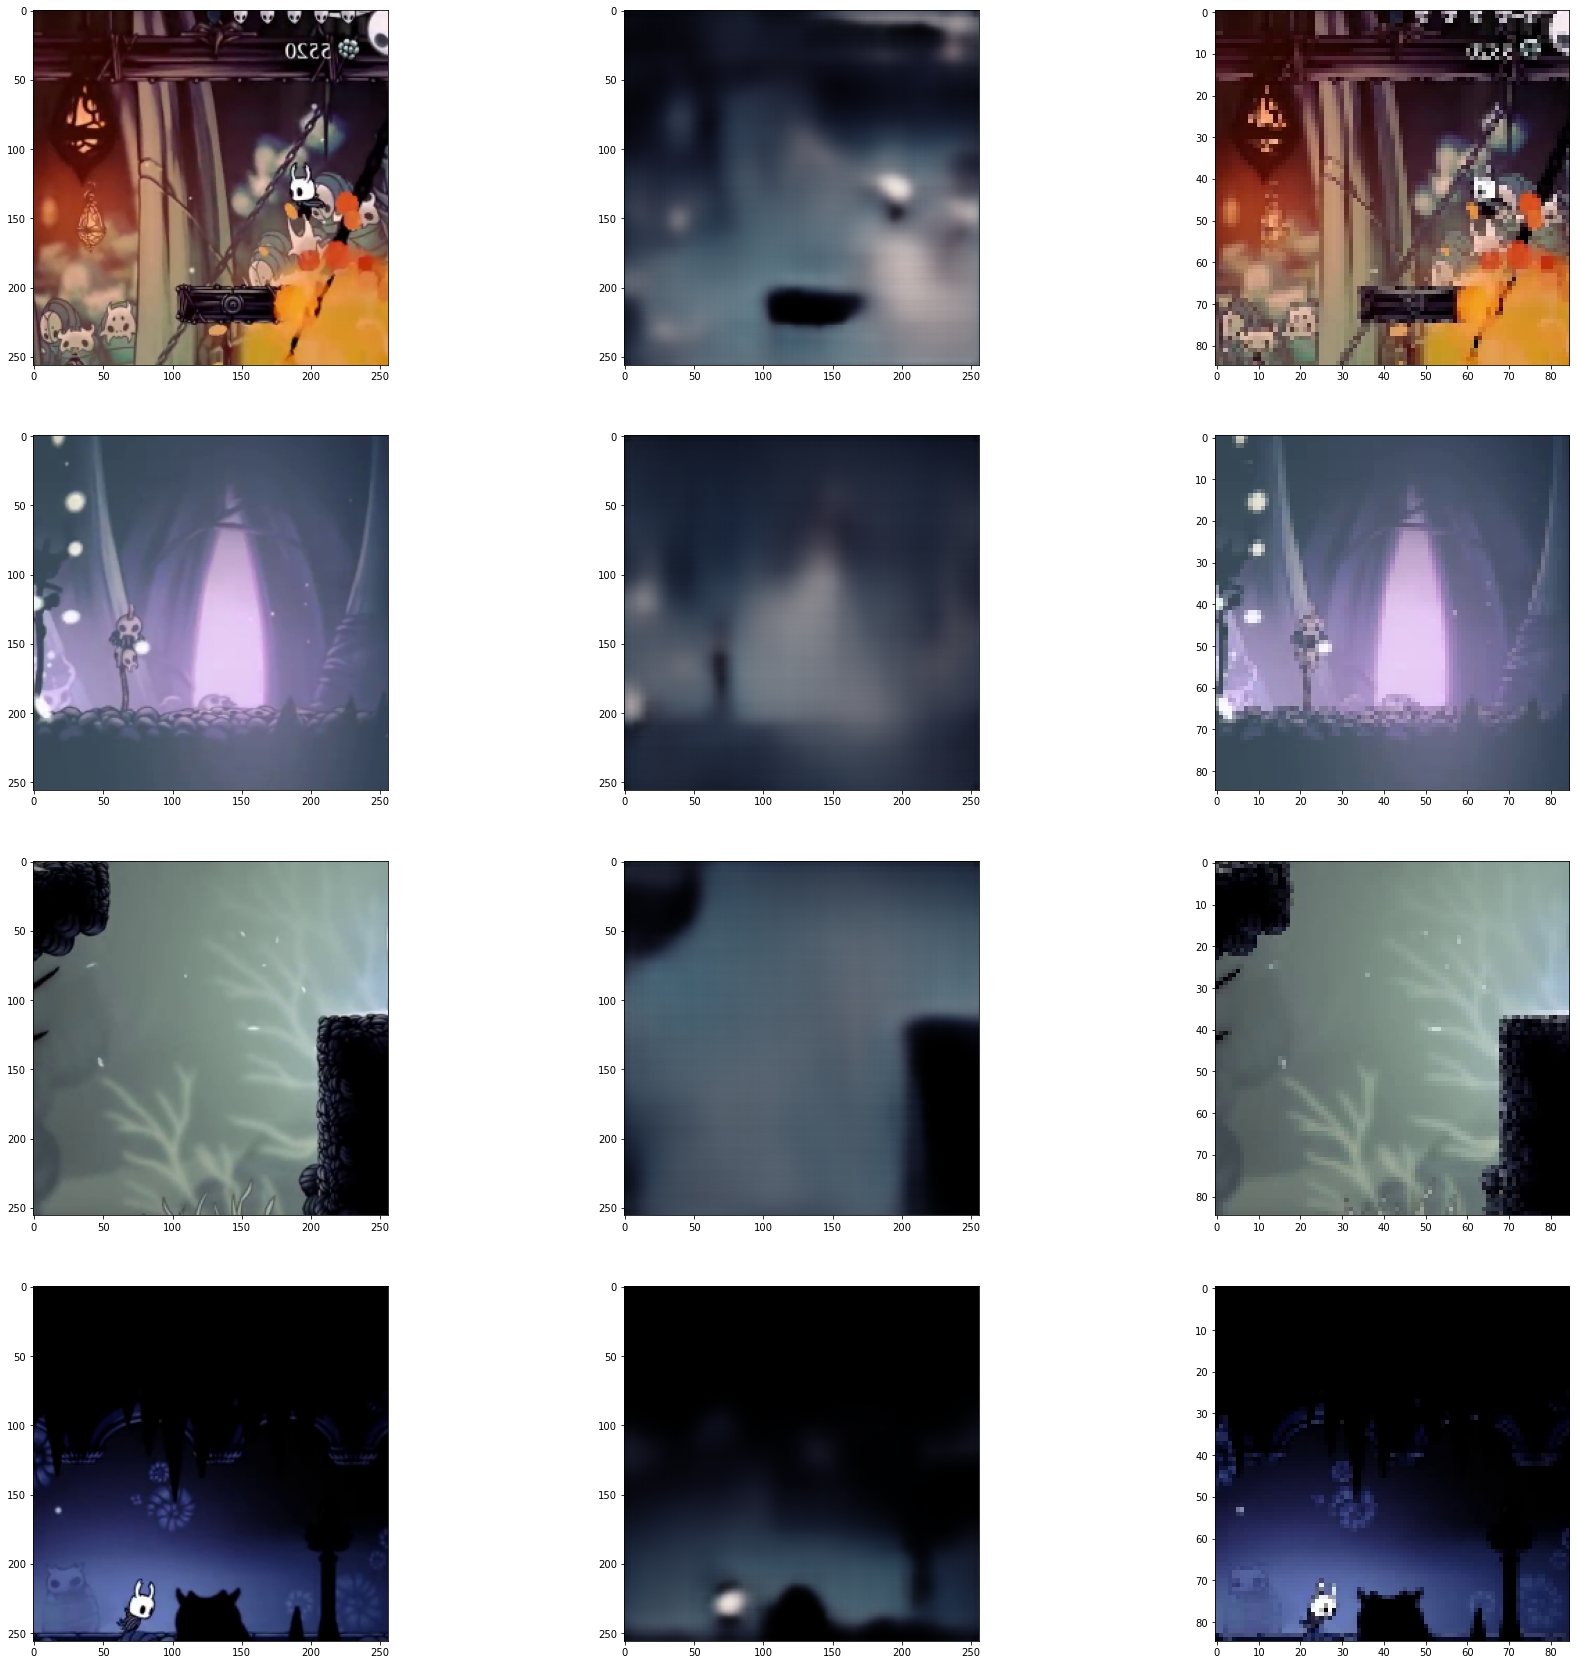

In [189]:
from matplotlib.pyplot import axes
import numpy as np
import cv2

img_number = 4
test_images = next(test_ds_prep)
test_images_input = test_images[0][:img_number]
test_images_output = test_images[1][:img_number]
decoded_imgs = model.predict(test_images_input)

print(np.min(test_images_input), np.max(test_images_input))
print(np.min(decoded_imgs), np.max(decoded_imgs), decoded_imgs.shape)
print(decoded_imgs[0])

fig = plt.figure(figsize=(30, 30))

for i, expected_img, out_img in zip(range(0, img_number, 1), test_images_output, decoded_imgs):
    plt.subplot(img_number, 3, i*3+1)
    plt.imshow(expected_img)
    plt.subplot(img_number, 3, i*3 + 2)
    plt.imshow(out_img)
    plt.subplot(img_number, 3, i*3 + 3)
    rescaled_img = cv2.resize(expected_img, (expected_img.shape[0] // 3, expected_img.shape[1] // 3))
    # manual_compression = tensorflow.cast(in_img*255. ,tensorflow.int32)
    # manual_compression = manual_compression - (manual_compression % 64)
    # manual_compression = tensorflow.cast(manual_compression ,tensorflow.float32)
    # manual_compression = tensorflow.cast(manual_compression/255. ,tensorflow.float32)
    plt.imshow(rescaled_img)
    # print(f'Image({i}) ms-ssim={ssim_loss(in_img, out_img):5.4f}, mae={np.mean(np.abs(in_img - out_img)):5.4f}, ms-ssim(manual)={ssim_loss(in_img, manual_compression):5.4f}, mae(manual)={np.mean(np.abs(in_img - manual_compression)):5.4f}')